# Beijing Multi-Site Air-Quality Data Set

In this notebook, we compare several imputation methods on a typical multi-variate timeseries dataset : the Beijing Multi-Site Air-Quality Data Set. It consists in hourly air pollutants data from 12 chinese nationally-controlled air-quality monitoring sites. 


In [1]:
import os
import warnings
import urllib.request
import zipfile
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from multits_imputer.impute import MultiTSImputer
import seaborn as sns
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## I. Load data

The dataset can be downloaded on the UCI Machine Learning repository with the following code :

In [2]:
urllink = "https://archive.ics.uci.edu/ml/machine-learning-databases/00501/"
datapath = "../data/"
zipname = "PRSA2017_Data_20130301-20170228"
download_data = True
if download_data:
    urllib.request.urlretrieve(urllink+zipname+".zip", datapath+zipname+".zip")
    with zipfile.ZipFile(datapath+zipname+".zip", "r") as zip_ref:
        zip_ref.extractall(datapath+zipname)

In [3]:
data_folder = os.listdir(datapath+zipname+"/")
data_files = os.listdir(datapath+zipname+"/"+data_folder[0])
cities = sorted([file.split("_")[2] for file in data_files])

In [4]:
dfs_init = {city: pd.read_csv(datapath+zipname+"/"+data_folder[0]+"/"+file) for city, file in zip(cities, data_files)}
for city, df in dfs_init.items():
    df.index = pd.to_datetime(df[["year", "month", "day", "hour"]])
    df = df.interpolate().ffill().bfill()
    # print(f"city: {df.shape}")

In [5]:
df_init = pd.concat(dfs_init)

In [6]:
cols = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
cols_sum = ["RAIN"]
cols_mean = list(set(cols) - set(cols_sum))
cols_imp = ["TEMP", "PRES", "DEWP"]
cols_time = ["year", "month", "day", "hour"]

In [7]:
df_init_day = pd.concat([
    df_init.groupby(["station", "year", "month", "day"])[cols_mean].mean(),
    df_init.groupby(["station", "year", "month", "day"])[cols_sum].sum(),
])
df_init_day["date"] = pd.to_datetime(df_init_day.reset_index()[["year", "month", "day"]]).values
# df_init_day["station"] = df_init_day.index.get_level_values(0)
df_init_day = df_init_day.reset_index().set_index(["station", "date"], drop=False)

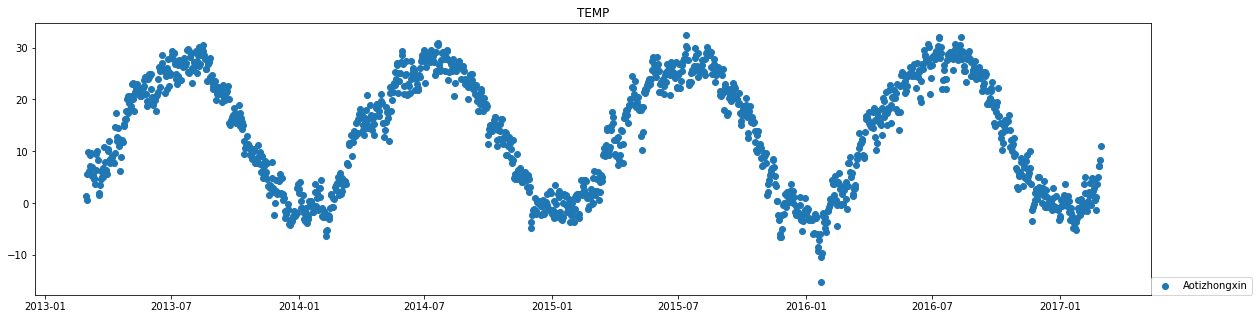

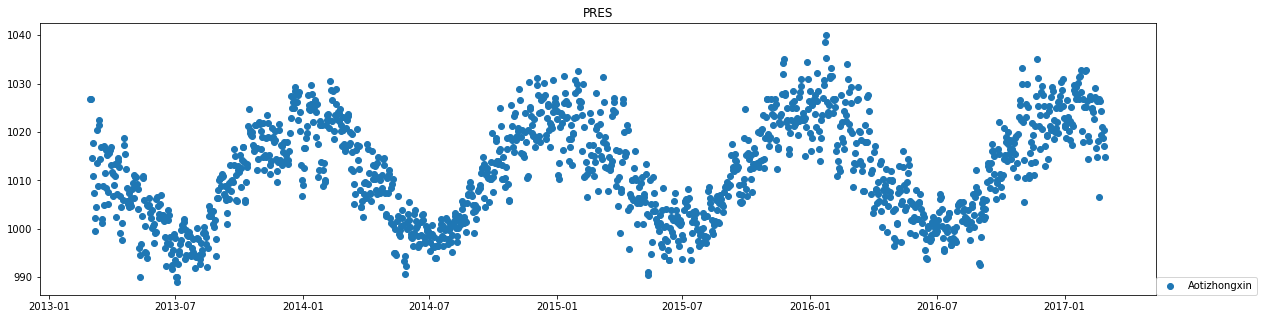

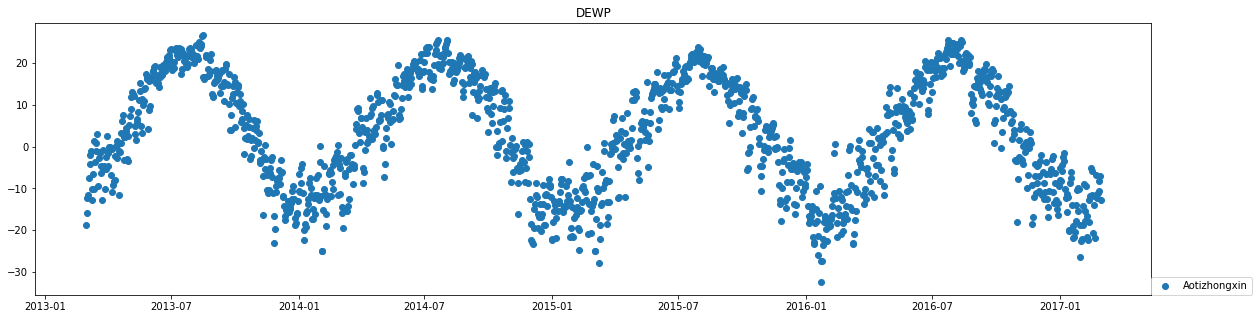

In [8]:
for col in cols_imp:
    plt.figure(figsize=(20, 5))
    for city in cities[:1]:
        plt.scatter(df_init_day.loc[city, col].index, df_init_day.loc[city, col], label=city)
    plt.title(col)
    plt.legend(loc=[1, 0])

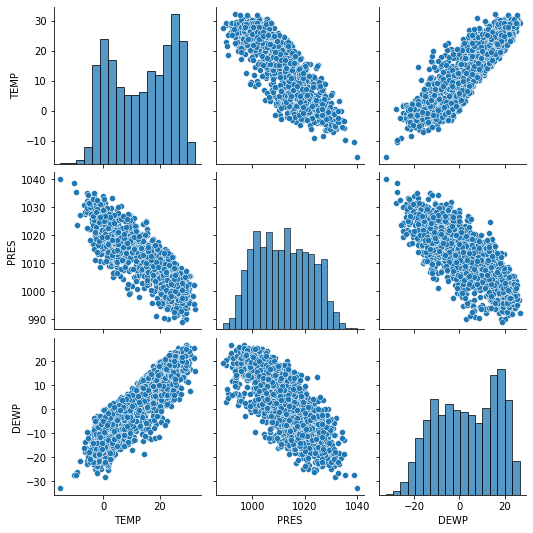

In [9]:
sns.pairplot(df_init_day.loc[cities[0], cols_imp])

## II. Corrupt data

In [10]:
df_corrupted = df_init_day[cols_imp].copy()

In [11]:
mask_pres = ~(df_corrupted.index.get_level_values(1).dayofweek == 1)
mask_dewp = (df_corrupted.index.get_level_values(1).month % 2 == 0)
masks = {cols_imp[0]: df_corrupted.index, cols_imp[1]: mask_pres, cols_imp[2]: mask_dewp}

In [12]:
df_corrupted.loc[mask_pres, "PRES"] = np.nan
df_corrupted.loc[mask_dewp, "DEWP"] = np.nan

## III. Imputation methods

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_to_impute = df_corrupted.loc[cities[0]].dropna(how="all")
mask_to_impute = df_to_impute.isna()

In [14]:
dfs_imputed = {
    "mean": SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_to_impute),
    "linear": df_to_impute.interpolate(),
    "iterative": IterativeImputer(sample_posterior=False, max_iter=100, missing_values=np.nan).fit_transform(df_to_impute),
    "multits": MultiTSImputer(n_iter_em=28, n_iter_ou=50, verbose=1).fit_transform(df_to_impute)
}
dfs_imputed = {name: pd.DataFrame(df, index=df_to_impute.index, columns=df_to_impute.columns) for name, df in dfs_imputed.items()}
methods = list(dfs_imputed.keys())

iter_em : 0/28
iter_em : 1/28
iter_em : 2/28
iter_em : 3/28
iter_em : 4/28
iter_em : 5/28
iter_em : 6/28
iter_em : 7/28
iter_em : 8/28
iter_em : 9/28
iter_em : 10/28
iter_em : 11/28
iter_em : 12/28
iter_em : 13/28
iter_em : 14/28
iter_em : 15/28
iter_em : 16/28
iter_em : 17/28
iter_em : 18/28
iter_em : 19/28
iter_em : 20/28
iter_em : 21/28
iter_em : 22/28
iter_em : 23/28
iter_em : 24/28
iter_em : 25/28
iter_em : 26/28
iter_em : 27/28


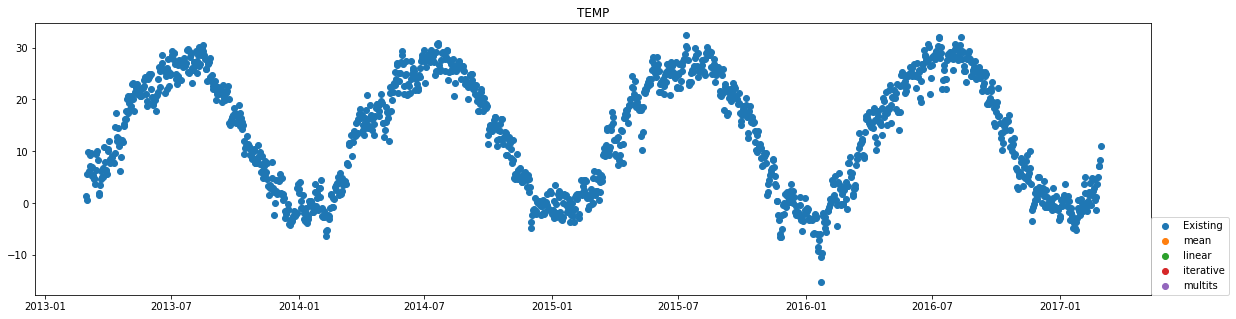

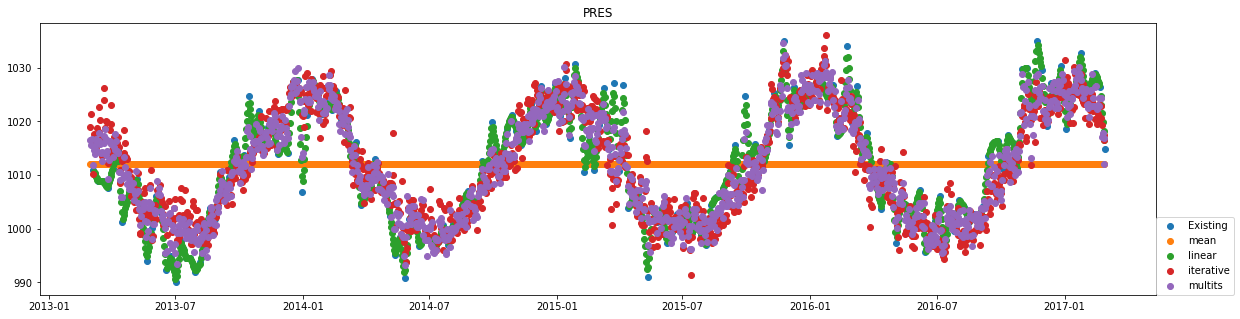

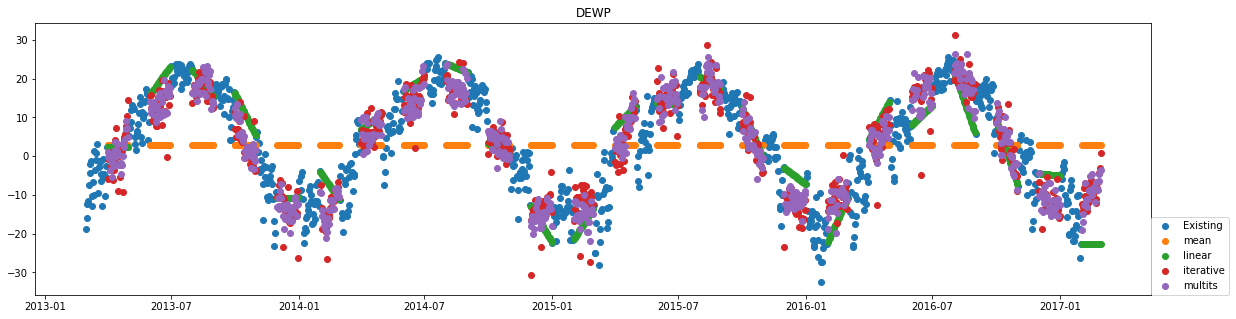

In [15]:
for col in cols_imp:
    plt.figure(figsize=(20, 5))
    plt.scatter(dfs_imputed[methods[0]][col][~mask_to_impute[col]].index, dfs_imputed[methods[0]][col][~mask_to_impute[col]], label="Existing")
    for name, df in dfs_imputed.items():
        plt.scatter(df[mask_to_impute[col]].index, df.loc[mask_to_impute[col], col], label=name)
    plt.title(col)
    plt.legend(loc=[1, 0])

## IV. Comparison of methods

### IV.a. Covariance

In [16]:
import matplotlib as mpl
colors = ["navy", "turquoise", "darkorange"]
def make_ellipses(X, ax, color):
    covariances = X.cov() # gmm.covariances_[0] # [n][:2, :2]
    # print(covariances)
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    center = X.mean() # .means_[0]
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        center, v[0], v[1], 180 + angle, color=color
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect("equal", "datalim")

In [17]:
def compare_covariances(df1, df2, var_x, var_y, ax):
    ax.scatter(df2[var_x], df2[var_y], marker=".", color="C1")
    ax.scatter(df1[var_x], df1[var_y], marker=".", color="C0")
    make_ellipses(df2[[var_x, var_y]], ax, "darkorange")
    make_ellipses(df1[[var_x, var_y]], ax, "turquoise")
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.legend(["After imputation", "Raw data"])

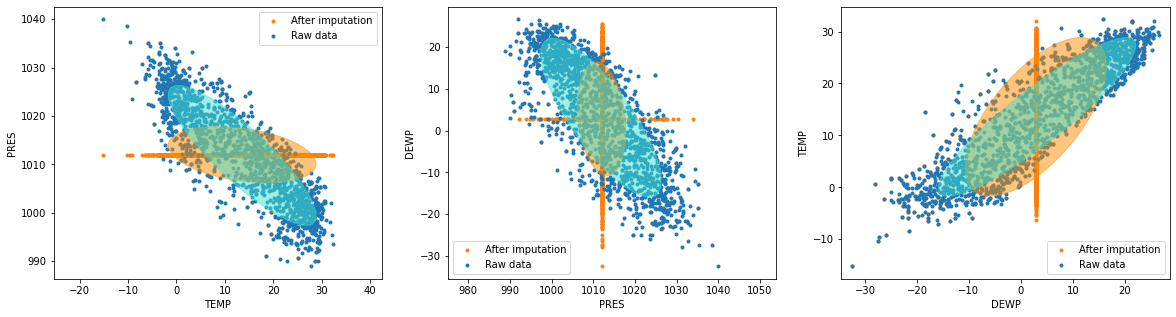

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["mean"], cols_imp[0], cols_imp[1], axs[0])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["mean"], cols_imp[1], cols_imp[2], axs[1])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["mean"], cols_imp[2], cols_imp[0], axs[2])

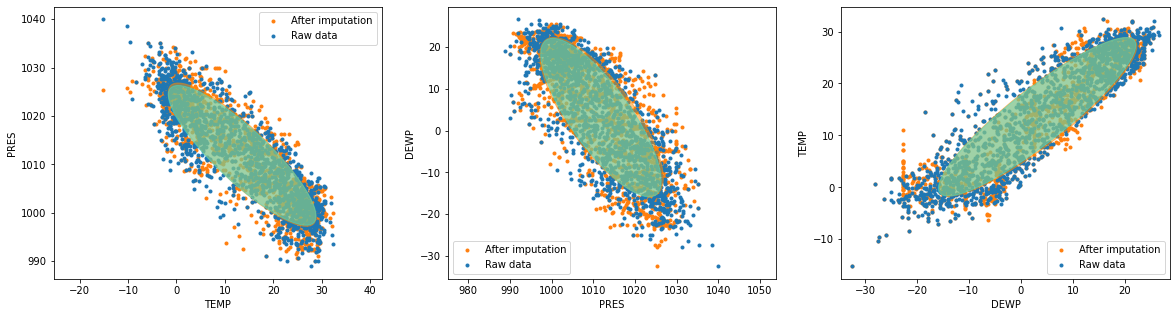

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["linear"], cols_imp[0], cols_imp[1], axs[0])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["linear"], cols_imp[1], cols_imp[2], axs[1])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["linear"], cols_imp[2], cols_imp[0], axs[2])

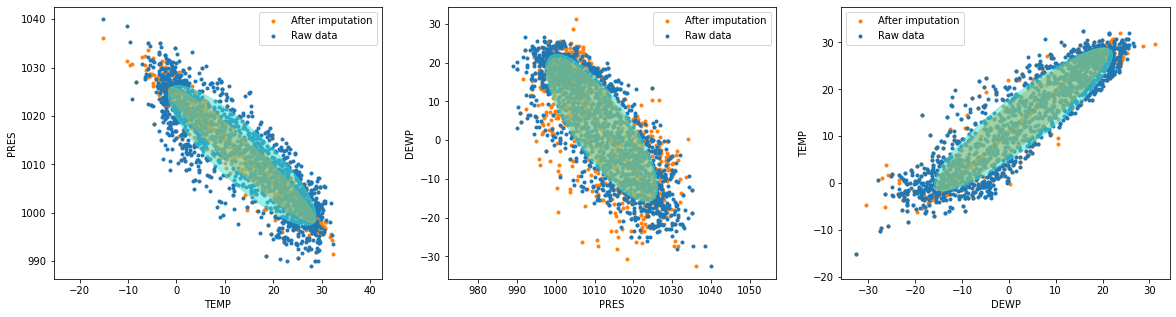

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["iterative"], cols_imp[0], cols_imp[1], axs[0])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["iterative"], cols_imp[1], cols_imp[2], axs[1])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["iterative"], cols_imp[2], cols_imp[0], axs[2])

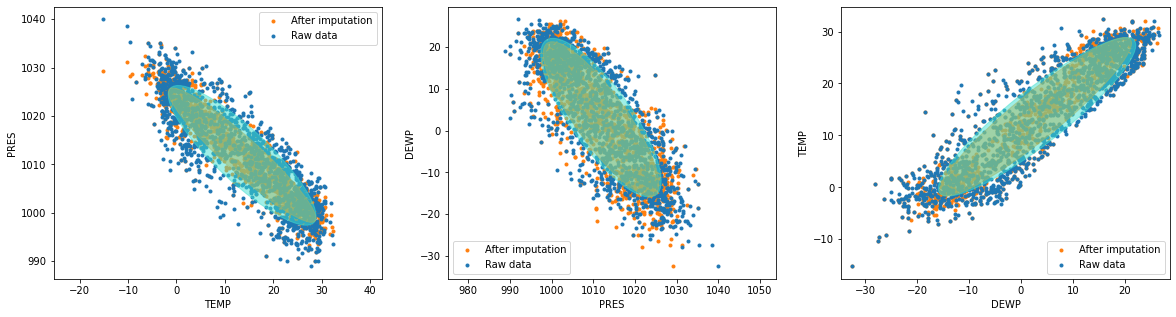

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["multits"], cols_imp[0], cols_imp[1], axs[0])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["multits"], cols_imp[1], cols_imp[2], axs[1])
compare_covariances(df_init_day.loc[cities[0], cols_imp], dfs_imputed["multits"], cols_imp[2], cols_imp[0], axs[2])

### IV.b. Coefficients of determination

In [22]:
from sklearn.metrics import r2_score
r2_scores = []
for name, df in dfs_imputed.items():
    r2_scores_ = []
    for col in cols_imp:
        r2_scores_.append(r2_score(df_init_day.loc[cities[0], col].dropna(how="all"), df[col].ffill().bfill()))
    r2_scores.append(r2_scores_)

In [23]:
r2_scores = pd.DataFrame(r2_scores, index=dfs_imputed.keys(), columns=cols_imp)

In [24]:
r2_scores

,TEMP,PRES,DEWP
mean,1.0,0.161224,0.512423
linear,1.0,0.767080,0.882194
iterative,1.0,0.743390,0.895052
multits,1.0,0.806043,0.910481


### IV.c. Auto-correlation

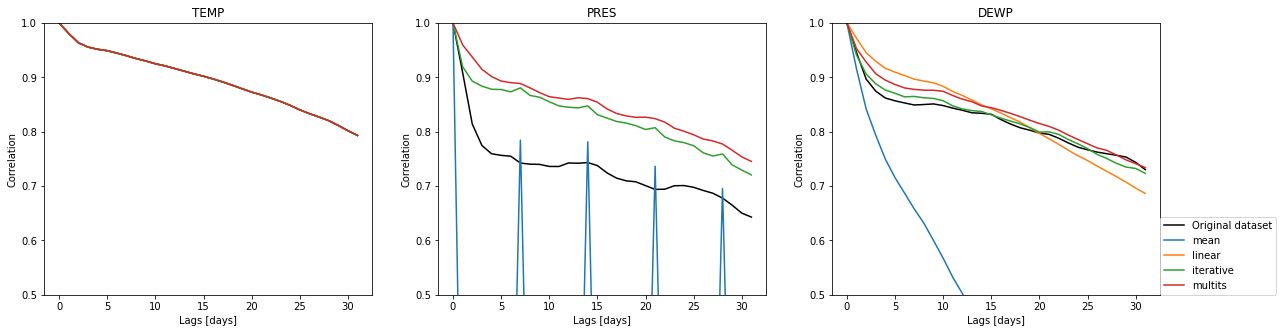

In [25]:
from statsmodels.tsa.stattools import acf
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, col in enumerate(cols_imp):
    axs[i].plot(acf(df_init_day.loc[cities[0], col].dropna()), color="k")
    for name, df in dfs_imputed.items():
        axs[i].plot(acf(df[col]))
    axs[i].set_xlabel("Lags [days]")
    axs[i].set_ylabel("Correlation")
    axs[i].set_ylim([0.5, 1])
    axs[i].set_title(col)
axs[-1].legend(["Original dataset"] +  list(dfs_imputed.keys()), loc=[1, 0])

### IV.d. Distances between distributions

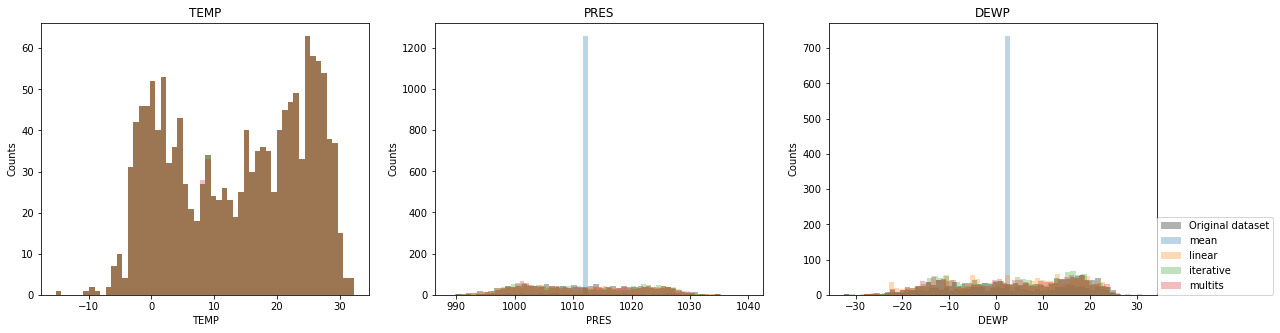

In [26]:
# from statsmodels.tsa.stattools import acf
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
n_samples = len(df_init_day.loc[cities[0], col])
for i, col in enumerate(cols_imp):
    axs[i].hist(df_init_day.loc[cities[0], col].dropna(), color="k", alpha=0.3, bins=int(np.sqrt(n_samples)))
    for name, df in dfs_imputed.items():
        axs[i].hist(df[col], alpha=0.3, bins=int(np.sqrt(n_samples)))
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Counts")
    # axs[i].set_ylim([0, dfs_imputed[methods[-1]][col].max()*1.5])
    axs[i].set_title(col)
axs[-1].legend(["Original dataset"] +  list(dfs_imputed.keys()), loc=[1, 0])

In [27]:
def KL(P, Q):
    """
    Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0.
    """
    epsilon = 0.00001

    P = P.copy() + epsilon
    Q = Q.copy() + epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

In [28]:
kl_divergences = []
for name, df in dfs_imputed.items():
    kl_divergences_ = []
    for col in cols_imp:
        kl_divergences_.append(KL(df_init_day.loc[cities[0], col].dropna(how="all"), df[col].ffill().bfill()))
    kl_divergences.append(kl_divergences_)
kl_divergences = pd.DataFrame(kl_divergences, index=dfs_imputed.keys(), columns=cols_imp)

In [29]:
kl_divergences

,TEMP,PRES,DEWP
mean,0.000000e+00,-152.946015,9453.086289
linear,0.000000e+00,-188.714151,449.577078
iterative,0.000000e+00,-68.047163,656.840538
multits,1.436642e-13,-45.808840,794.625876
